In [2]:
import matplotlib.pyplot as plt

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy.core.event import Event
from obspy.core.event import Origin
from obspy.core.event import Magnitude
from obspy import read_events
from obspy import read_inventory
import cartopy.crs as ccrs

import pickle


In [ ]:
catINGV=read_events('flegrei_2014_2023_INGV/catalogue_flegrei.xml')
catOV=read_events('flegrei_2014_2023_GOSSIP/catalogue_flegrei.xml')

In [ ]:
id_catalogues=[]

for ind,ev in enumerate(catINGV):
    
    origin_time = ev.origins[0].time
    time_min= 'time > ' + str(origin_time - 5)
    time_max= 'time < ' + str(origin_time + 5)
    cat= catOV.filter(time_min , time_max)

    id_catalogues.append([])
    id_catalogues[ind].append(str(ev.resource_id)[-8:])
    #id_catalogues[ind].append(int(str(ev.resource_id)[-8:]))


    for match in cat:
        id_catalogues[ind].append(str(match.resource_id)[-8:])
        #id_catalogues[ind].append(int(str(match.resource_id)[-8:]))


id_catalogues

In [ ]:
print( 'len INGV:', len(catINGV), 'len comparison:', len(id_catalogues) )

## save

In [ ]:
with open("event_comparison_INGV_GOSSIP", "wb") as fp:   #Pickling
    pickle.dump(id_catalogues, fp)

## load

In [ ]:
with open("event_comparison_INGV_GOSSIP", "rb") as fp:   # Unpickling
    catalogues = pickle.load(fp)

In [ ]:
catalogues[0:6]

In [ ]:
ev_not_found=[]
ev_multiple_det=[]

for ev in catalogues:
    if len(ev)   >= 3:
        ev_multiple_det.append(ev)
    elif len(ev) == 1:
        ev_not_found.append(ev)
    elif len(ev) != 2:
        print('!event not categorized!')
        

In [ ]:
ev_multiple_det

In [ ]:
ev_not_found

# Waveform 

In [5]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Stream
from obspy import read, read_inventory
from obspy.core import AttribDict
from obspy.core.event import Pick, WaveformStreamID, Arrival, Amplitude
from obspy.core.event import Event, Origin, Magnitude
from obspy.core.event import EventDescription, CreationInfo
from obspy import read
import obspy
import os
#import geopy.distance

#### Define the client
client = Client("INGV")

# Questo è il tempo origine del terrmoto, derivato dal catalogo
torig=UTCDateTime(2023,9,22,9,2,0)
t1=torig-60         # taglia le tracce 60s prima del tempo origine
t2=torig+120        # taglia le tracce 60s dopo il tempo origine


### define pre-filtering for instr. correction
pre_filt = [0.01, 0.1, 25,30]

pnet='IV'
psta='CMIS'
wildcmp='HH*' #HH Broad Band, for moment tensor inversion
outdir="./waveform/"

# Get the waveforms from t1 to t2  
st = client.get_waveforms(network=pnet, station=psta, location='*',
                          channel=wildcmp,starttime=t1,endtime=t2)
                    
# merge the traces, in case there are holes
st.merge(fill_value=0)
# trim over the [t1, t2] interval
st.trim(starttime=t1, endtime=t2, pad=True, fill_value=0)
# remove trend
st.detrend("demean")
                                    
# Get the instrument characteristics
rinv=client.get_stations(network=pnet,station=psta,
                         channel=wildcmp,level='response')

# 
st.remove_response(inventory=rinv, output='DISP', pre_filt=pre_filt)

st.write(outdir+'test.mseed',format='MSEED')

/Users/user/Library/Python/3.9/lib/python/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


In [15]:
st[0].__dict__
#type(st)

{'stats':                network: IV
               station: CMIS
              location: 
               channel: HHE
             starttime: 2023-09-22T09:01:00.000000Z
               endtime: 2023-09-22T09:04:00.000000Z
         sampling_rate: 100.0
                 delta: 0.01
                  npts: 18001
                 calib: 1.0
_fdsnws_dataselect_url: http://webservices.ingv.it/fdsnws/dataselect/1/query
               _format: MSEED
                 mseed: AttribDict({'dataquality': 'D', 'number_of_records': 93, 'encoding': 'STEIM1', 'byteorder': '>', 'record_length': 512, 'filesize': 141312})
            processing: ['ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 9, 22, 9, 4)::fill_value=None::nearest_sample=True::pad=False::starttime=UTCDateTime(2023, 9, 22, 9, 1))', 'ObsPy 1.4.0: trim(endtime=UTCDateTime(2023, 9, 22, 9, 4)::fill_value=0::nearest_sample=True::pad=True::starttime=UTCDateTime(2023, 9, 22, 9, 1))', "ObsPy 1.4.0: detrend(options={}::type='demean')", "ObsPy 1.4.0:

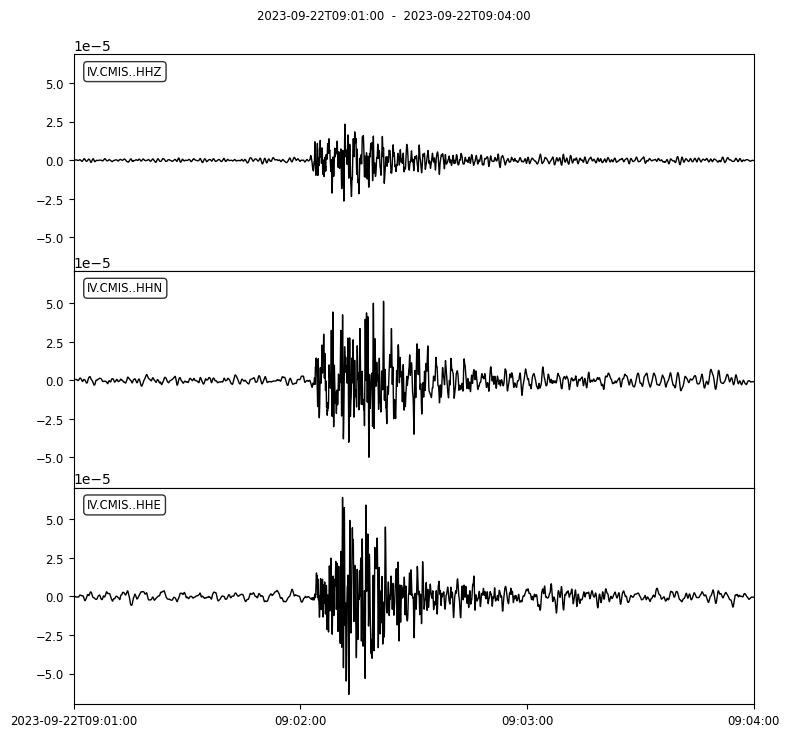

In [9]:
st.plot();